# Project: **Finding Lane Lines on the Road** 
***
In this project, I used the tools to identify lane lines on the road.  I developed a pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images).

Afterwards, I averaged/extrapolated the line segments I've detected to map out the full extent of the lane lines. Ultimately, you I managed to draw one line for the left side of the lane, and one for the right.

**The tools I used are color selection, region of interest selection, grey scaling, Gaussian smoothing, Canny Edge Detection and Hough Transform line detection. Final goal is to create a pipeline to detect the line segments in the image, then average/extrapolate them and apply a working pipeline on a video stream. **

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


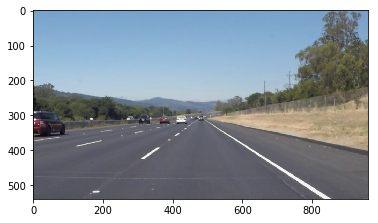

In [2]:
# reading in an image
# please be sure that following image exists in the folder.
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10, lineType = 'L'):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for x1,y1,x2,y2 in line_average(lines, img.shape, lineType)[0]:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, lineType = 'L'):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(img = line_img, lines = lines, lineType = lineType)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), an image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Average coordinates
def line_average(lines, imshape, lineType = 'L'):
    if lineType == 'L':
        t = 0.45
    else:
        t = 0.55
    aver_coord = np.average(lines, axis = 0)
    #Y = slope * X + beta
    slope = (aver_coord[0][3] - aver_coord[0][1]) / (aver_coord[0][2] - aver_coord[0][0])
    beta = aver_coord[0][3] - slope * aver_coord[0][2]
    Y0 = imshape[0]
    X0 = int((Y0 - beta)/slope)
    X1 = int(t * imshape[1])
    Y1 = int(slope * X1 + beta)
    return np.array([[[X0, Y0, X1, Y1]]])

## Test Images

Building a pipeline to work on the images in the directory "test_images"  

In [4]:
import os
folder = "test_images/"
img_dir = os.listdir(folder)

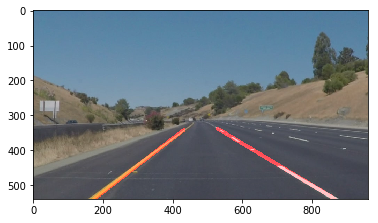

In [5]:
# Build a pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def pipeline(img, kernel_size = 3, low_threshold = 50, high_threshold = 150, rho = 2,
            theta = 1*np.pi/180, threshold = 45, min_line_length = 100, max_line_gap = 200):
    # Apply gray filter
    gray = grayscale(img)
    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, kernel_size)
    # Apply Canny
    edges = canny(blur_gray, low_threshold, high_threshold)
    # Create a masked edges image
    # Define a four sided polygon to mask
    imshape = img.shape
    #vertices = np.array([[(0,imshape[0]),(int(0.5*imshape[1]), int(0.6*imshape[0])), (int(0.5*imshape[1]), int(0.58*imshape[0])), (imshape[1],imshape[0])]], dtype=np.int32)
    # Create separate vertices for each line
    vertices_L = np.array([[(0,imshape[0]),(int(0.5*imshape[1]), int(0.55*imshape[0])), (int(0.5*imshape[1]), imshape[0])]], dtype=np.int32)
    vertices_R = np.array([[(int(0.5*imshape[1]),imshape[0]),(int(0.5*imshape[1]), int(0.55*imshape[0])), (imshape[1], imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)

    masked_edges_L = region_of_interest(edges, vertices_L)
    masked_edges_R = region_of_interest(edges, vertices_R)
    # Run Hough on edge detected image
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image_L = hough_lines(masked_edges_L, rho, theta, threshold, min_line_length, max_line_gap, lineType = 'L')
    line_image_R = hough_lines(masked_edges_R, rho, theta, threshold, min_line_length, max_line_gap, lineType = 'R')
    # Draw the lines on the edge imag
    line_image = weighted_img(line_image_R, line_image_L, 1,1)
    lines_edges = weighted_img(line_image, img)
    return lines_edges

image_name = folder + img_dir[5]
image = mpimg.imread(image_name)
with_lines_image = pipeline(image)
plt.imshow(with_lines_image)

In [6]:
# Save the images
img_dir = os.listdir(folder)
for i in range(len(img_dir)):
    image_name = folder + img_dir[i]
    image = mpimg.imread(image_name)
    with_lines_image = pipeline(image)
    name_to_save = 'with_lines_' + img_dir[i][:-3] + 'png'
    mpimg.imsave(fname = folder + name_to_save , arr=with_lines_image, format='png')
    print('saving    with_lines_' + name_to_save)

saving    with_lines_with_lines_whiteCarLaneSwitch.png
saving    with_lines_with_lines_solidYellowLeft.png
saving    with_lines_with_lines_solidYellowCurve.png
saving    with_lines_with_lines_solidWhiteCurve.png
saving    with_lines_with_lines_solidWhiteRight.png
saving    with_lines_with_lines_solidYellowCurve2.png


## Build a Lane Finding Pipeline



Build the pipeline and run it on all test_images.

Tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos

Drawing lanes over video having final pipeline.

There are two videos in the `test_videos` folder: `solidWhiteRight.mp4`, `solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # return the final output (image where lines are drawn on lanes)
    return pipeline(img = image)

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 34.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.66 s, sys: 276 ms, total: 5.94 s
Wall time: 7.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:22<00:00, 30.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 17.8 s, sys: 660 ms, total: 18.5 s
Wall time: 23.4 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))